# Yöntem 2: Saatlik Fiyat Tahmini için RNN Model Eğitimi

Bu notebook, bir önceki `feature_engineering` adımında saatlik tahmin hedefi (`target_price_1h`) için hazırlanan verileri kullanarak bir sonraki saatin elektrik fiyatını tahmin edecek bir RNN modeli geliştirmeyi amaçlamaktadır.

Süreç, günlük model eğitimine benzer şekilde ilerleyecektir:
1.  Gerekli kütüphanelerin yüklenmesi.
2.  İşlenmiş saatlik verilerin ve öznitelik ölçekleyicisinin yüklenmesi.
3.  Hedef değişken için özel bir ölçekleyici oluşturulması.
4.  Bir başlangıç (baseline) modeli oluşturulup eğitilmesi ve performansının değerlendirilmesi.
5.  Keras Tuner ile hiperparametre optimizasyonu yaparak en iyi modelin bulunması.
6.  Optimize edilmiş modelin nihai performansının değerlendirilmesi ve diske kaydedilmesi.

### 1. Kütüphanelerin Yüklenmesi ve Ortam Hazırlığı

Gerekli olan `TensorFlow`, `Keras`, `scikit-learn` gibi kütüphaneleri yüklüyor ve veri/model yollarını tanımlıyoruz.

In [ ]:
import numpy as np
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Attention
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)

DATA_PATH = '../../data/processed/'
MODEL_PATH = '../../models/'
os.makedirs(MODEL_PATH, exist_ok=True)

### 2. İşlenmiş Verilerin Yüklenmesi

Önceki adımda oluşturulan saatlik model verilerini yüklüyoruz.

- **`hourly_model_data.npz`**: Saatlik tahmin için hazırlanmış eğitim, validasyon ve test dizilerini içerir. Dizi uzunluğu burada 24 saat olarak belirlenmiştir.
- **`scaler_1h.joblib`**: Saatlik modelin özniteliklerini [0, 1] aralığına ölçeklendirmek için kullanılan `MinMaxScaler` nesnesidir.

In [ ]:
processed_data = np.load(os.path.join(DATA_PATH, 'hourly_model_data.npz'))
X_train = processed_data['X_train']
y_train = processed_data['y_train']
X_val = processed_data['X_val']
y_val = processed_data['y_val']
X_test = processed_data['X_test']
y_test = processed_data['y_test']

scaler_features = joblib.load(os.path.join(DATA_PATH, 'scaler_1h.joblib'))

print("Veri Seti Boyutları:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Veri Seti Boyutları:
X_train: (24221, 24, 111), y_train: (24221,)
X_val: (5171, 24, 111), y_val: (5171,)
X_test: (5172, 24, 111), y_test: (5172,)


### 3. Hedef Değişken için Ölçekleyici (Target Scaler) Oluşturma

Öznitelik mühendisliği aşamasında, her iki modelin de öznitelikleri ölçeklendirilmişti. Ancak hedef değişkenler (`target_price_1h` ve `target_price_next_day`) farklı dağılımlara sahip olduğu için her birine özel bir ölçekleyici kullanmak daha doğru sonuçlar verir.

Bu adımda, saatlik hedefe (`y_train`) özel yeni bir `MinMaxScaler` oluşturuyor, eğitiyor ve tüm hedef setlerini (train, val, test) bu ölçekleyici ile dönüştürüyoruz.
- **Kaydedilen Dosya**: Bu ölçekleyici, daha sonra tahminleri orijinal birime çevirmek için `MODEL_PATH` altında **`scaler_target_1h.joblib`** adıyla kaydedilir.

In [ ]:
scaler_target = MinMaxScaler()

y_train_scaled = scaler_target.fit_transform(y_train.reshape(-1, 1))

y_val_scaled = scaler_target.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_test.reshape(-1, 1))

joblib.dump(scaler_target, os.path.join(MODEL_PATH, 'scaler_target_1h.joblib'))

print("Hedef değişken (y) başarıyla ölçeklendirildi ve scaler kaydedildi.")

Hedef değişken (y) başarıyla ölçeklendirildi ve scaler kaydedildi.


### 4. Başlangıç Modelinin Oluşturulması ve Eğitimi

Hiperparametre optimizasyonu öncesi bir referans noktası oluşturmak amacıyla, günlük modele benzer bir mimariye sahip başlangıç modeli tanımlanır.

#### 4.1. Model Mimarisi
- **`Input` Katmanı**: `(24, 111)` boyutunda, yani 24 saatlik dizileri ve 111 özniteliği kabul eder.
- **`GRU`, `Attention`, `Dense` ve `Dropout` katmanları**: Zaman içindeki desenleri öğrenmek, önemli anlara odaklanmak ve tahmini üretmek için kullanılır.

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling1D

SEQUENCE_LENGTH = X_train.shape[1]
NUM_FEATURES = X_train.shape[2]

# onksiyonel API ile model oluşturma
input_layer = Input(shape=(SEQUENCE_LENGTH, NUM_FEATURES), name='input_layer')

# GRU katmanı
gru_layer = GRU(units=128, return_sequences=True, name='gru_layer')(input_layer)

#attention katmanı
attention_layer = Attention(name='attention_layer')([gru_layer, gru_layer])

pooling_layer= GlobalAveragePooling1D(name='pooling_layer')(attention_layer)

# MLP başlığı artık bu tek vektör üzerinden çalışacak
dense_1 = Dense(64, activation='relu', name='dense_1')(pooling_layer)
dropout_1 = Dropout(0.3, name='dropout_1')(dense_1)
dense_2 = Dense(32, activation='relu', name='dense_2')(dropout_1)
dropout_2 = Dropout(0.3, name='dropout_2')(dense_2)

# Çıkış katmanı
output_layer = Dense(1, name='output_layer')(dropout_2)

# Modeli tanımla
model = Model(inputs=input_layer, outputs=output_layer)

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 111)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_layer (GRU)     │ (None, 24, 128)   │     92,544 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 24, 128)   │          0 │ gru_layer[0][0],  │
│ (Attention)         │                   │            │ gru_layer[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling_layer       │ (None, 128)       │          0 │ attention_layer[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ pooling_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 1)         │         33 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,913 (402.00 KB)

 Trainable params: 102,913 (402.00 KB)

 Non-trainable params: 0 (0.00 B)

#### 4.2. Modelin Derlenmesi ve Geri Çağrıların (Callbacks) Tanımlanması

Model, `adam` optimize edici ve `mean_squared_error` kayıp fonksiyonu ile derlenir. Eğitim sürecini yönetmek için `ModelCheckpoint` ve `EarlyStopping` kullanılır.
- **Kaydedilen Dosya**: Bu adımda, eğitim sırasındaki en iyi performansı gösteren model, `MODEL_PATH` altında **`best_hourly_model.keras`** adıyla kaydedilir. (Not: kodunuzda `.h5` kullanılmış, bu da geçerlidir ancak `.keras` daha modern bir formattır).

In [ ]:
# En iyi modeli kaydetmek için ModelCheckpoint
checkpoint_path = os.path.join(MODEL_PATH, 'best_hourly_model.keras') # .keras formatı önerilir
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Aşırı öğrenmeyi önlemek için EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10, # 10 epoch boyunca iyileşme olmazsa durur
    restore_best_weights=True,
    verbose=1
)

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

#### 4.2. Modelin Derlenmesi ve Geri Çağrıların (Callbacks) Tanımlanması

Model, `adam` optimize edici ve `mean_squared_error` kayıp fonksiyonu ile derlenir. Eğitim sürecini yönetmek için `ModelCheckpoint` ve `EarlyStopping` kullanılır.
- **Kaydedilen Dosya**: Bu adımda, eğitim sırasındaki en iyi performansı gösteren model, `MODEL_PATH` altında **`best_hourly_model.keras`** adıyla kaydedilir. (Not: kodunuzda `.h5` kullanılmış, bu da geçerlidir ancak `.keras` daha modern bir formattır).

In [14]:
EPOCHS = 100
BATCH_SIZE = 64

history = model.fit(
    X_train, y_train_scaled,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val_scaled),
)



Epoch 1/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0382 - mean_absolute_error: 0.1413 - val_loss: 0.0083 - val_mean_absolute_error: 0.0727
Epoch 2/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0091 - mean_absolute_error: 0.0736 - val_loss: 0.0072 - val_mean_absolute_error: 0.0674
Epoch 3/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0064 - mean_absolute_error: 0.0616 - val_loss: 0.0051 - val_mean_absolute_error: 0.0537
Epoch 4/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0050 - mean_absolute_error: 0.0536 - val_loss: 0.0049 - val_mean_absolute_error: 0.0529
Epoch 5/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0039 - mean_absolute_error: 0.0470 - val_loss: 0.0055 - val_mean_absolute_error: 0.0572
Epoch 6/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0034 - mean_absolute_error: 0.0434 - val_loss: 0.0044 - val_mean_absolute_error: 0.0493
Epoch 7/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0032 - mean_absolute_err

#### 4.4. Eğitim Geçmişinin Görselleştirilmesi

Eğitim sürecindeki kayıp (loss) ve ortalama mutlak hata (MAE) metriklerinin değişimi, modelin öğrenme eğrisini anlamak için görselleştirilir.

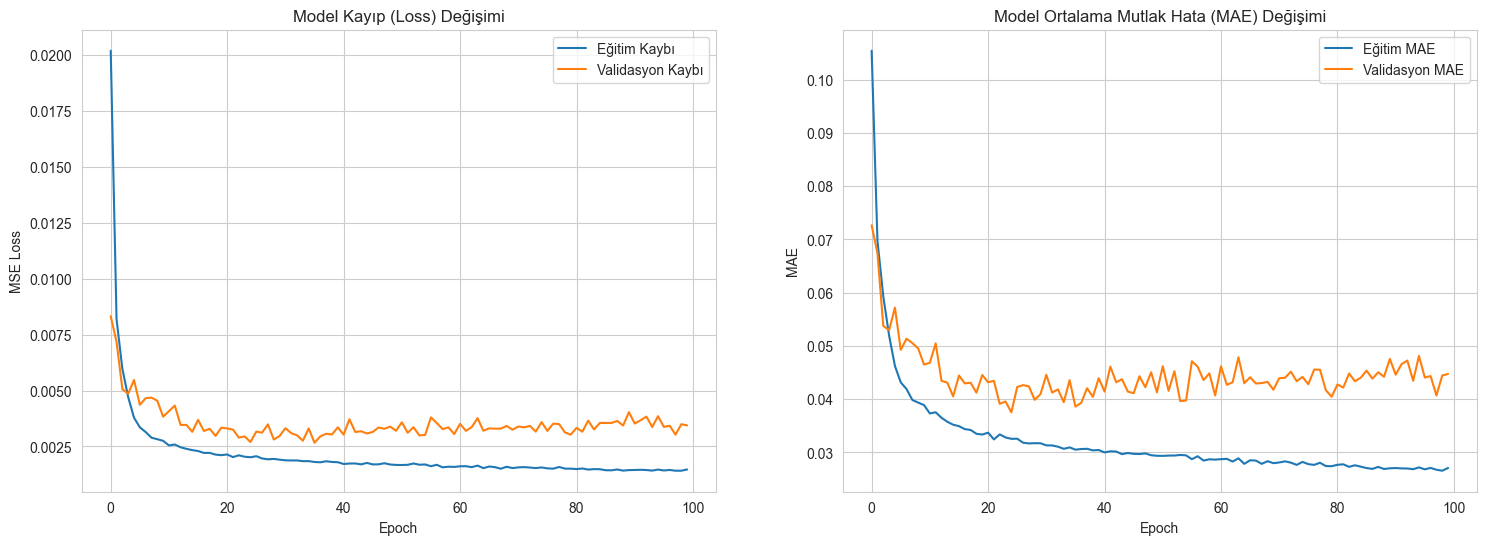

In [15]:

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Kayıp (Loss) Grafiği
    ax1.plot(history.history['loss'], label='Eğitim Kaybı')
    ax1.plot(history.history['val_loss'], label='Validasyon Kaybı')
    ax1.set_title('Model Kayıp (Loss) Değişimi')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.legend()

    # Metrik (MAE) Grafiği
    ax2.plot(history.history['mean_absolute_error'], label='Eğitim MAE')
    ax2.plot(history.history['val_mean_absolute_error'], label='Validasyon MAE')
    ax2.set_title('Model Ortalama Mutlak Hata (MAE) Değişimi')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()

    plt.show()

plot_training_history(history)
    

#### 4.5. Başlangıç Modelinin Test Performansı

Eğitilen başlangıç modelinin performansı, daha önce hiç görmediği test verisi üzerinde ölçülür. Tahminler, `scaler_target_1h` kullanılarak orijinal Euro birimine çevrilir ve metrikler hesaplanır.

In [16]:
from tensorflow.keras.models import load_model

# Kaydedilen en iyi modeli yükle
# Not: Eğer model .h5 olarak kaydedildiyse, özel katmanlar (Attention) için bir uyarı verebilir.
# .keras formatı genellikle daha sorunsuzdur.
checkpoint_path = os.path.join(MODEL_PATH, 'best_hourly_model.h5')
best_model = load_model(checkpoint_path)

# Test seti üzerinde tahmin yap
y_pred_scaled = best_model.predict(X_test)

# Tahminleri ve gerçek değerleri orijinal ölçeğe geri döndür
y_pred_original = scaler_target.inverse_transform(y_pred_scaled)
y_test_original = scaler_target.inverse_transform(y_test_scaled)

# Performans metriklerini hesapla
mae_original = mean_absolute_error(y_test_original, y_pred_original)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

print("-" * 50)
print("Test Seti Performans Değerlendirmesi (Orijinal Ölçek)")
print(f"Ortalama Mutlak Hata (MAE): {mae_original:.2f} Euro")
print(f"Kök Ortalama Kare Hata (RMSE): {rmse_original:.2f} Euro")
print("-" * 50)

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
--------------------------------------------------
Test Seti Performans Değerlendirmesi (Orijinal Ölçek)
Ortalama Mutlak Hata (MAE): 13.58 Euro
Kök Ortalama Kare Hata (RMSE): 15.38 Euro
--------------------------------------------------


### 5. Hiperparametre Optimizasyonu (Keras Tuner)

Başlangıç modelinin performansını daha da ileriye taşımak için `Keras Tuner` ile en uygun hiperparametre setini arıyoruz.

- **`build_model(hp)` fonksiyonu**: GRU ve Dense katmanlarındaki ünite sayısı, dropout oranı ve öğrenme oranı gibi parametreler için bir arama uzayı tanımlar.
- **`RandomSearch`**: Belirlenen arama uzayında rastgele kombinasyonlar deneyerek en iyi modeli bulmaya çalışan bir arama stratejisidir.

In [ ]:
# Gerekliyse KerasTuner'ı kurun (bu satırı bir kere çalıştırdıktan sonra yorum satırı yapabilirsiniz)
!pip install -q -U keras-tuner

import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    """
    KerasTuner için hiperparametre arama uzayını tanımlayan 
    ve modeli oluşturan fonksiyon.
    """
    # Model giriş katmanı
    input_layer = Input(shape=(SEQUENCE_LENGTH, NUM_FEATURES))

    #GRU Ünite Sayısı: 32 ile 256 arasında, 32'lik adımlarla dene
    hp_gru_units = hp.Int('gru_units', min_value=32, max_value=256, step=32)
    
    # Dense Katman-1 Ünite Sayısı: 32 ile 128 arasında, 32'lik adımlarla dene
    hp_dense_1_units = hp.Int('dense_1_units', min_value=32, max_value=128, step=32)

    # Dense Katman-2 Ünite Sayısı: 16 ile 64 arasında, 16'lık adımlarla dene
    hp_dense_2_units = hp.Int('dense_2_units', min_value=16, max_value=64, step=16)

    # Dropout Oranı: 0.1 ile 0.5 arasında bir değer dene
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)

    # Öğrenme Oranı: Belirtilen seçeneklerden birini dene
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 5e-4])

    gru_layer = GRU(units=hp_gru_units, return_sequences=True)(input_layer)
    attention_layer = Attention()([gru_layer, gru_layer])
    pooling_layer = GlobalAveragePooling1D()(attention_layer)
    
    dense_1 = Dense(units=hp_dense_1_units, activation='relu')(pooling_layer)
    dropout_1 = Dropout(rate=hp_dropout)(dense_1)
    dense_2 = Dense(units=hp_dense_2_units, activation='relu')(dropout_1)
    dropout_2 = Dropout(rate=hp_dropout)(dense_2)
    
    output_layer = Dense(1)(dropout_2)

    model = Model(inputs=input_layer, outputs=output_layer)

    # Modeli derle
    optimizer = Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

#### 5.1. Optimizasyon Sürecinin Başlatılması
`tuner.search()` metodu ile arama süreci başlatılır. Her deneme (`trial`), `EarlyStopping` ile desteklenerek verimsiz denemelerin erken sonlandırılması sağlanır.
- **Kaydedilen Dosyalar**: Tuner, tüm deneme sonuçlarını **`keras_tuner_dir/hourly_price_tuning/`** klasörüne kaydeder.

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,
    executions_per_trial=2,
    directory='keras_tuner_dir',
    project_name='hourly_price_tuning',
    overwrite=True 
)

# Erken durdurma callback'i
early_stopping_tuner = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

print("\nHiperparametre arama süreci başlıyor...")
tuner.search(
    X_train, y_train_scaled,
    epochs=50,
    validation_data=(X_val, y_val_scaled),
    callbacks=[early_stopping_tuner]
)

print("\nArama tamamlandı.")

Trial 15 Complete [00h 05m 58s]
val_loss: 0.002272792044095695

Best val_loss So Far: 0.0018198565230704844
Total elapsed time: 02h 22m 47s

Arama tamamlandı.


### 6. Final Modelin Değerlendirilmesi ve Kaydedilmesi

Optimizasyon tamamlandıktan sonra, en iyi performansı gösteren hiperparametrelerle oluşturulmuş model alınır ve test seti üzerinde nihai performansı ölçülür.

- **Kaydedilen Dosya**: Optimize edilmiş en iyi saatlik tahmin modeli, `MODEL_PATH` altında **`best_tuned_hourly_model.keras`** adıyla kaydedilir.

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nEn İyi Hiperparametreler:")
print(f"- GRU Üniteleri: {best_hps.get('gru_units')}")
print(f"- Dense-1 Üniteleri: {best_hps.get('dense_1_units')}")
print(f"- Dense-2 Üniteleri: {best_hps.get('dense_2_units')}")
print(f"- Dropout Oranı: {best_hps.get('dropout_rate'):.2f}")
print(f"- Öğrenme Oranı: {best_hps.get('learning_rate')}")

best_model = tuner.get_best_models(num_models=1)[0]

# En iyi model ile test seti üzerinde performans değerlendirmesi
print("\n--- En İyi Modelin Test Performansı ---")
y_pred_scaled_best = best_model.predict(X_test)
y_pred_original_best = scaler_target.inverse_transform(y_pred_scaled_best)

mae_original_best = mean_absolute_error(y_test_original, y_pred_original_best)
rmse_original_best = np.sqrt(mean_squared_error(y_test_original, y_pred_original_best))

print("-" * 50)
print("Test Seti Performans Değerlendirmesi (Orijinal Ölçek)")
print(f"Ortalama Mutlak Hata (MAE): {mae_original_best:.2f} Euro")
print(f"Kök Ortalama Kare Hata (RMSE): {rmse_original_best:.2f} Euro")
print("-" * 50)

# İsteğe bağlı: En iyi modeli diske kaydet
best_model.save(os.path.join(MODEL_PATH, 'best_tuned_hourly_model.keras'))


En İyi Hiperparametreler:
- GRU Üniteleri: 224
- Dense-1 Üniteleri: 96
- Dense-2 Üniteleri: 48
- Dropout Oranı: 0.10
- Öğrenme Oranı: 0.001


c:\Users\90537\anaconda3\envs\tf-env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



--- En İyi Modelin Test Performansı ---
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
--------------------------------------------------
Test Seti Performans Değerlendirmesi (Orijinal Ölçek)
Ortalama Mutlak Hata (MAE): 2.60 Euro
Kök Ortalama Kare Hata (RMSE): 3.21 Euro
--------------------------------------------------
